In [1]:
import numpy as np
# import cupy as cp
from numba import cuda
import numba
import math
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pickle

In [2]:
# device function   
@cuda.jit(device=True)
def calc_pix_val(rf, px, pz, angle, elx, c, fs):
    """
    Device function. 
    Returns the value in single pixel of the reconstructed image 
    for Plane Wave Imaging scheme with tx angle = 0 degree.

    rf: 2D array of ultrasound signals acquired by the transducer. 
        rf.shape = (number_of_elements, number_of_samples)
    px: x coordinate of the image pixel,
    pz: z coordinate of the image pixel,
    angle: wave angle of incidence,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,

    """
    
    if angle >= 0:
        pw = elx[0]
    else:
        pw = elx[-1]
        
    n_samples = rf.shape[-1]
    # sum suitable samples from signals acquired by each transducer element
    pixval = 0
    for ielement in range(elx.shape[0]):
        sample_number = round((pz*math.cos(angle) 
                               - pw*math.sin(angle) 
                               + px*math.sin(angle) 
                               + math.sqrt(pz**2 + (px-elx[ielement])**2)
                              )/c*fs)
        if sample_number < n_samples:
            pixval += rf[ielement,sample_number]


    return pixval    
    
    
# kernel    
@cuda.jit
def reconstruct(image, rf, xgrid, zgrid, angle, elx, c, fs):
    """
    Kernel function.
    Enumerates values in all pixels of the reconstructed image
    for Plane Wave Imaging scheme with tx angle = 0 degree.
    
    image: pre-allocated device ndarray for image data
    rf: ultrasound signals acquired by the transducer,
    xgrid: 2D array of image pixels x coordinates,
    zgrid: 2D array of image pixels z coordinates,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,
    
    """
    
    


    i, j, k = cuda.grid(3)
    if i > image.shape[0] or j > image.shape[1] or k > image.shape[2]:
        return
    
    # kernel does not return a value - it modifies one of arguments into result
    image[i,j,k] = calc_pix_val(rf[k, :, :], 
                                xgrid[i, j], zgrid[i, j], angle[k], 
                                elx, c, fs)
    
    

def beamform(rf, xgrid, zgrid, angle, pitch, c, fs):
    """
    Function beamforming ultrasound data into image using GPU kernel.
    Returns beamformed image (ndarray).

    xgrid: 2D array of image pixels x coordinates,
    zgrid: 2D array of image pixels z coordinates,
    elx: vector of x coordinates of the transducer elements,
    c: speed of sound in the medium,
    fs: sampling frequency,
    rf: ultrasound signals acquired by the transducer,
    """
    n_transmissions, n_channels, n_samples = rf.shape    
    probe_width = (n_channels-1)*pitch
    elx = np.linspace(-probe_width/2, probe_width/2, n_channels)

    
    # allocate output array on the device
    nx = xgrid.shape[1]
    nz = zgrid.shape[0]
    ny = angle.size
    print(f'the size of img array: {(nz,nx,ny)}')
    img = cuda.device_array((nz,nx,ny))
    
    # put data and grid arrays to the device
    xgrid = cuda.to_device(xgrid)
    zgrid = cuda.to_device(zgrid)
    angle = cuda.to_device(angle)
    elx = cuda.to_device(elx)
    print(f'the size of imput rf array'
          f'before cuda.to_device(rf): {(nz,nx,ny)}')
    rf = np.ascontiguousarray(rf)
#     print(rf.flags['C_CONTIGUOUS'])
    rf = cuda.to_device(rf)

    
    
    # define thread per block and blocks per grid size
    # Note: total number of threads in block should not be bigger than 1024/512 (hardware dependent)
    blockshape = (8,8,ny)
    gridshape_z = (nz + blockshape[0] - 1) // blockshape[0]
    gridshape_x = (nx + blockshape[1] - 1) // blockshape[1]
    gridshape_y = (ny + blockshape[2] - 1) // blockshape[2]
    gridshape = (gridshape_z, gridshape_x, gridshape_y)
    
    # run kernel
#     with cuda.defer_cleanup():
    reconstruct[gridshape,blockshape](img, rf, xgrid, zgrid, angle, elx, c, fs)
    
    # transfer data from device to host
    img = img.copy_to_host()
    return img

def to_bmode(img):
    """
    Auxiliary function for image envelope detection and log-compression.
    """
    
    env = np.abs(signal.hilbert(img,axis=0))
    mx = np.max(env)
    env = env/mx
    env = 20*np.log10(env)
    return env


def create_grid(x_mm, z_mm, nx=256, nz=256):

    xgrid = np.linspace(x_mm[0]*1e-3,x_mm[1]*1e-3,nx)
    xgrid = np.expand_dims(xgrid,axis=0)
    xgrid = np.tile(xgrid,(nz,1))

    zgrid = np.linspace(z_mm[0]*1e-3,z_mm[1]*1e-3,nz)
    zgrid = np.expand_dims(zgrid,axis=1)
    zgrid = np.tile(zgrid,(1,nx))
    
    return xgrid, zgrid

def create_bmode(img, x, z):
    """
    Auxiliary function for b-mode image creation.
    """    
    fig,ax = plt.subplots(nrows=1, ncols=1)
    ax.set_xlabel('[mm]')
    ax.set_ylabel('[mm]')
    ax.imshow(
        to_bmode(img),
        extent = x+z[::-1],
        cmap='gray',
        vmin = -30,
        vmax = 0,
             )
    
def load_mat_data(filename):
    data = loadmat('sim_single_cyst.mat')
    fs = np.squeeze(data['fs']) # sampling frequency
    fs = np.float64(fs)
    c = np.squeeze(data['c']) # speed of sound
    # when c is uint16 it raise error, thus it should be casted into proper type
    c = np.float64(c)
    pitch = np.squeeze(data['pitch']) # pitch
    angles = np.squeeze(data['angles']) # transmit angles
    rf = np.squeeze(data['rf']) # radio-frequency (rf) data acquired by probe elements
    rf = np.transpose(rf,(2,1,0))
    # decimation - the fs=1e8 is not necessary high
    dec = 4
    rf = signal.decimate(rf, dec)
    fs = fs/dec
    
    return rf, angles, pitch, c, fs

    

### Load data form mat file 

In [3]:
data = loadmat('./data/sim_single_cyst.mat')
print(data.keys())

fs = np.squeeze(data['fs']) # sampling frequency
fs = np.float64(fs)
c = np.squeeze(data['c']) # speed of sound
# when c is uint16 it raise error, thus it should be casted into proper type
c = np.float64(c)

pitch = np.squeeze(data['pitch']) # pitch
angles = np.squeeze(data['angles']) # transmit angles

rf = np.squeeze(data['rf']) # radio-frequency (rf) data acquired by probe elements
rf = np.transpose(rf,(2,1,0))
# decimation - the fs=1e8 is not necessary high
dec = 4
rf = signal.decimate(rf, dec)
fs = fs/dec

x_mm = [-15,15]
z_mm = [20,50]
xgrid, zgrid = create_grid(x_mm, z_mm)

%time rfbmf = beamform(rf, xgrid, zgrid, angles, pitch, c, fs)

dict_keys(['__header__', '__version__', '__globals__', 'angles', 'c', 'fc', 'fs', 'pitch', 'rf', 'rfrc'])
the size of img array: (256, 256, 5)
the size of imput rf arraybefore cuda.to_device(rf): (256, 256, 5)
CPU times: user 423 ms, sys: 2.5 s, total: 2.93 s
Wall time: 3.29 s


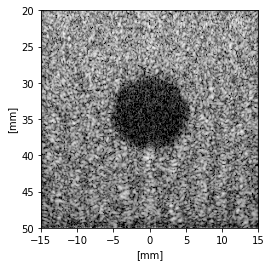

In [4]:
create_bmode(np.sum(rfbmf,2), x_mm, z_mm)

